In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=relu, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 200,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = False))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 50
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])


Checkpoint 50, Accuracy: 0.8333333333333334, Loss: 0.6898846096462674
Checkpoint 100, Accuracy: 0.8395061728395061, Loss: 0.6722857863814743
Checkpoint 150, Accuracy: 0.8333333333333334, Loss: 0.6775112152099609
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6828455748381438
Checkpoint 250, Accuracy: 0.8395061728395061, Loss: 0.68542155513057
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6815020949752243
Checkpoint 350, Accuracy: 0.8395061728395061, Loss: 0.6786862126103154
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.682443760059498
Checkpoint 450, Accuracy: 0.8395061728395061, Loss: 0.682443760059498
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.682443760059498


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.9194301 ]
 [0.0610025 ]
 [0.01956735]]
[1. 0. 0.] <-> [[0.8355653 ]
 [0.11654445]
 [0.04789025]]
[1. 0. 0.] <-> [[0.96287185]
 [0.02973619]
 [0.00739189]]
[1. 0. 0.] <-> [[0.9752525 ]
 [0.02031794]
 [0.00442955]]
[0. 1. 0.] <-> [[0.34024376]
 [0.36436468]
 [0.29539153]]
[1. 0. 0.] <-> [[0.9602285 ]
 [0.03171065]
 [0.00806085]]
[1. 0. 0.] <-> [[0.8317938 ]
 [0.11893017]
 [0.04927609]]
[1. 0. 0.] <-> [[0.6532441 ]
 [0.22315073]
 [0.12360516]]
[1. 0. 0.] <-> [[0.96334124]
 [0.02938442]
 [0.00727434]]
[1. 0. 0.] <-> [[0.95648164]
 [0.03449008]
 [0.00902817]]
[1. 0. 0.] <-> [[0.81301224]
 [0.13068567]
 [0.05630219]]
[1. 0. 0.] <-> [[0.9010083 ]
 [0.07366079]
 [0.02533087]]
[1. 0. 0.] <-> [[0.8594853 ]
 [0.10120852]
 [0.03930605]]
[1. 0. 0.] <-> [[0.9109585 ]
 [0.06686086]
 [0.02218057]]
[1. 0. 0.] <-> [[0.89348555]
 [0.0787473 ]
 [0.0277671 ]]
[1. 0. 0.] <-> [[0.39435846]
 [0.34459284]
 [0.26104867]]
[0. 1. 0.] <-> [[0.17959669]
 [0.4027143 ]
 [0.41768906]]
[1. 0. 0.] <->

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


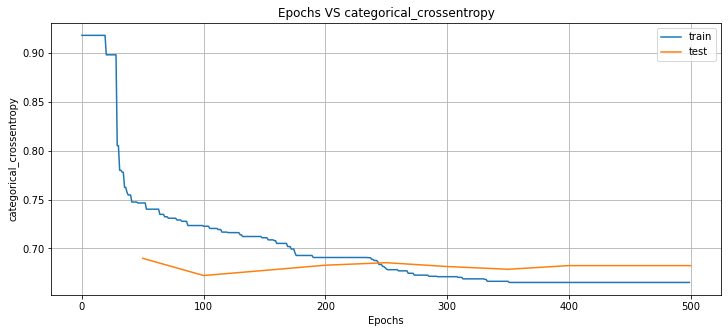

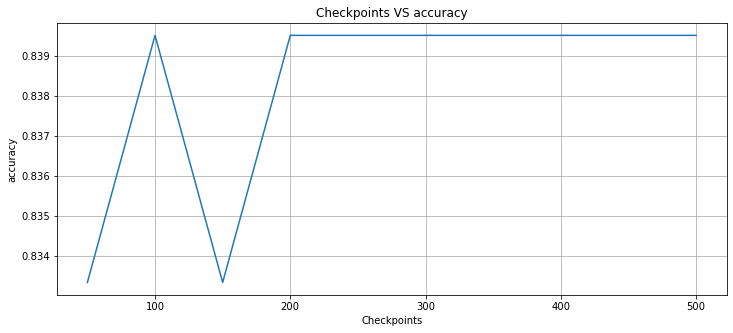

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.9911092069668865, 'categorical_crossentropy': 0.6898846096462674, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 50} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9426767805572838, 'categorical_crossentropy': 0.6722857863814743, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 2, 'fp_hit': 2, 'tn_hit': 92, 'fn_hit': 12}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.8682743136953155, 'categorical_crossentropy': 0.6775112152099609, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.02446653]
 [ 0.03133754]
 [-0.41802314]
 [-0.23610304]
 [-0.1150777 ]]
 bias: [0.15815067]

Neuron 1: weights:
[[-0.05456872]
 [ 0.0673876 ]
 [-0.5417234 ]
 [-0.07765021]
 [-0.2835602 ]]
 bias: [1.0095316]

Neuron 2: weights:
[[ 0.04630681]
 [-0.00542743]
 [-0.18135504]
 [ 0.35940486]
 [-0.13832936]]
 bias: [-0.0635049]

Neuron 3: weights:
[[-0.00713813]
 [-0.1074212 ]
 [ 0.3315152 ]
 [-0.02208536]
 [-0.03475492]]
 bias: [-0.10425084]

$
Layer 2
Neuron 0: weights:
[[0.18967885]
 [0.8540873 ]
 [0.07914778]
 [0.14458627]]
 bias: [0.09969825]

Neuron 1: weights:
[[-0.0876549 ]
 [-0.05792054]
 [ 0.05828807]
 [ 0.00575815]]
 bias: [-0.27694187]

Neuron 2: weights:
[[ 0.01459952]
 [-0.51959693]
 [-0.06344531]
 [ 0.0084017 ]]
 bias: [-0.50902146]

$

